# Data Preparation Complete - Walmart Sales Forecast

Notebook này thực hiện toàn bộ các bước chuẩn bị dữ liệu theo file "[Các bước làm tham khảo tiếp theo]".

## Cấu trúc:

**GIAI ĐOẠN 1: CHUẨN BỊ DỮ LIỆU**
- 1.1. Tạo df_main_weekly
- 1.2. Tạo df_events_daily  
- 1.3. Tạo df_feature_calendar_weekly

**GIAI ĐOẠN 2: FEATURE ENGINEERING**
- 2.1. Merge & Kiểm tra
- 2.2. Tạo Features "Payday Pulse"
- 2.3. Tạo Features "Holiday"
- 2.4. Tạo Features "Lag/Rolling"
- 2.5. Tạo Features "Interaction"

**GIAI ĐOẠN 3: LƯU CÁC FILE OUTPUT**

---


## 0. Setup và Import Libraries


In [3]:
# Import các thư viện cần thiết
import pandas as pd
import numpy as np
import warnings
import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import normaltest
import missingno as msno

warnings.filterwarnings('ignore')

# Cấu hình pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

# Cấu hình matplotlib và seaborn
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 12

# Tạo thư mục figures nếu chưa có
os.makedirs('../figures', exist_ok=True)

print("✅ Libraries imported successfully!")


✅ Libraries imported successfully!


### Helper Functions

Định nghĩa các helper functions (từ file `data_prep_utils.py`)


In [4]:
def get_us_holidays(year):
    """Tính các ngày lễ Mỹ cho một năm"""
    holidays = {}
    
    holidays[f'{year}-01-01'] = ('New Years Day', 1)
    
    # Super Bowl
    super_bowl_dates = {2010: '2010-02-07', 2011: '2011-02-06', 2012: '2012-02-05'}
    if year in super_bowl_dates:
        holidays[super_bowl_dates[year]] = ('Super Bowl', 3)
    
    # Presidents Day
    presidents_day_dates = {2010: '2010-02-15', 2011: '2011-02-21', 2012: '2012-02-20'}
    if year in presidents_day_dates:
        holidays[presidents_day_dates[year]] = ('Presidents Day', 1)
    
    # Memorial Day
    memorial_day_dates = {2010: '2010-05-31', 2011: '2011-05-30', 2012: '2012-05-28'}
    if year in memorial_day_dates:
        holidays[memorial_day_dates[year]] = ('Memorial Day', 1)
    
    holidays[f'{year}-07-04'] = ('Independence Day', 1)
    
    # Labor Day
    labor_day_dates = {2010: '2010-09-06', 2011: '2011-09-05', 2012: '2012-09-03'}
    if year in labor_day_dates:
        holidays[labor_day_dates[year]] = ('Labor Day', 3)
    
    # Thanksgiving
    thanksgiving_dates = {2010: '2010-11-25', 2011: '2011-11-24', 2012: '2012-11-22'}
    if year in thanksgiving_dates:
        holidays[thanksgiving_dates[year]] = ('Thanksgiving', 5)
    
    holidays[f'{year}-12-25'] = ('Christmas', 5)
    holidays[f'{year}-12-24'] = ('Christmas Eve', 3)
    
    return holidays


def get_week_end_date(date):
    """Tính WeekEndDate (Thứ Sáu cuối tuần) cho một ngày"""
    weekday = date.weekday()  # 0=Monday, 4=Friday, 6=Sunday
    if weekday == 4:  # Friday
        return date
    elif weekday == 5:  # Saturday
        return date + timedelta(days=6)
    elif weekday == 6:  # Sunday
        return date + timedelta(days=5)
    else:  # Monday-Thursday
        return date + timedelta(days=4-weekday)


def is_tax_refund_season(date):
    """Kiểm tra xem ngày có thuộc mùa hoàn thuế không (15/02 - 15/04)"""
    month = date.month
    day = date.day
    if month == 2 and day >= 15:
        return 1
    elif month == 3:
        return 1
    elif month == 4 and day <= 15:
        return 1
    return 0


def calculate_weeks_since_payday(group):
    """Tính số tuần kể từ payday gần nhất cho mỗi group (Store, Dept)"""
    weeks_since = []
    last_payday_week = None
    
    for idx, row in group.iterrows():
        if row['is_semimonthly_payweek'] == 1:
            last_payday_week = row['WeekEndDate']
            weeks_since.append(0)
        elif last_payday_week is not None:
            weeks_diff = (row['WeekEndDate'] - last_payday_week).days // 7
            weeks_since.append(weeks_diff)
        else:
            weeks_since.append(np.nan)
    
    return pd.Series(weeks_since, index=group.index)


def piecewise_decay(weeks):
    """Tính giá trị decay theo piecewise function"""
    if weeks == 0:
        return 1.0
    elif weeks == 1:
        return 0.7
    elif weeks >= 2:
        return 0.4
    else:
        return 0.0


def get_christmas_date(year):
    """Trả về ngày Giáng sinh"""
    return pd.Timestamp(f'{year}-12-25')


def get_thanksgiving_date(year):
    """Tính ngày Thanksgiving (Thứ 5 thứ 4 của tháng 11)"""
    nov_1 = pd.Timestamp(f'{year}-11-01')
    first_thursday = nov_1 + timedelta(days=(3 - nov_1.weekday()) % 7)
    if first_thursday.day > 7:
        first_thursday = first_thursday - timedelta(days=7)
    thanksgiving = first_thursday + timedelta(days=21)
    return thanksgiving


def calculate_weeks_until_holiday(date, holiday_func):
    """Tính số tuần cho đến lễ tiếp theo"""
    year = date.year
    holiday_date = holiday_func(year)
    
    # Nếu lễ đã qua trong năm này, tính lễ năm sau
    if date > holiday_date:
        holiday_date = holiday_func(year + 1)
    
    weeks_diff = (holiday_date - date).days // 7
    return weeks_diff

print("✅ Helper functions defined!")


✅ Helper functions defined!


In [5]:
# Cấu hình đường dẫn
DATA_PATH = '../data/'
PROCESSED_PATH = '../data/processed/'


print(f"📁 Data path: {DATA_PATH}")
print(f"📁 Processed path: {PROCESSED_PATH}")


📁 Data path: ../data/
📁 Processed path: ../data/processed/


---

# 📊 SECTION 1: DATA QUALITY ASSESSMENT

**Mục tiêu:** Đánh giá chất lượng dữ liệu trước khi xử lý và feature engineering.

## 1.1. Missing Values Analysis


In [6]:
# Load dữ liệu để phân tích missing values
print("🔄 Loading datasets for quality assessment...")
train_df = pd.read_csv(DATA_PATH + 'train.csv')
stores_df = pd.read_csv(DATA_PATH + 'stores.csv')
features_df = pd.read_csv(DATA_PATH + 'features.csv')

# Merge để có full dataset
df_merged = pd.merge(train_df, stores_df, on='Store', how='left')
df_merged = pd.merge(df_merged, features_df, on=['Store', 'Date'], how='left', suffixes=('', '_features'))

if 'IsHoliday_features' in df_merged.columns:
    df_merged = df_merged.drop(columns=['IsHoliday_features'])

print(f"✅ Merged data shape: {df_merged.shape}")
print(f"\nMissing values per column:")
missing_summary = df_merged.isnull().sum()
missing_pct = (missing_summary / len(df_merged)) * 100
missing_df = pd.DataFrame({
    'Missing Count': missing_summary,
    'Missing %': missing_pct
}).sort_values('Missing Count', ascending=False)
print(missing_df[missing_df['Missing Count'] > 0])


🔄 Loading datasets for quality assessment...
✅ Merged data shape: (421570, 16)

Missing values per column:
           Missing Count  Missing %
MarkDown2         310322  73.611025
MarkDown4         286603  67.984676
MarkDown3         284479  67.480845
MarkDown1         270889  64.257181
MarkDown5         270138  64.079038


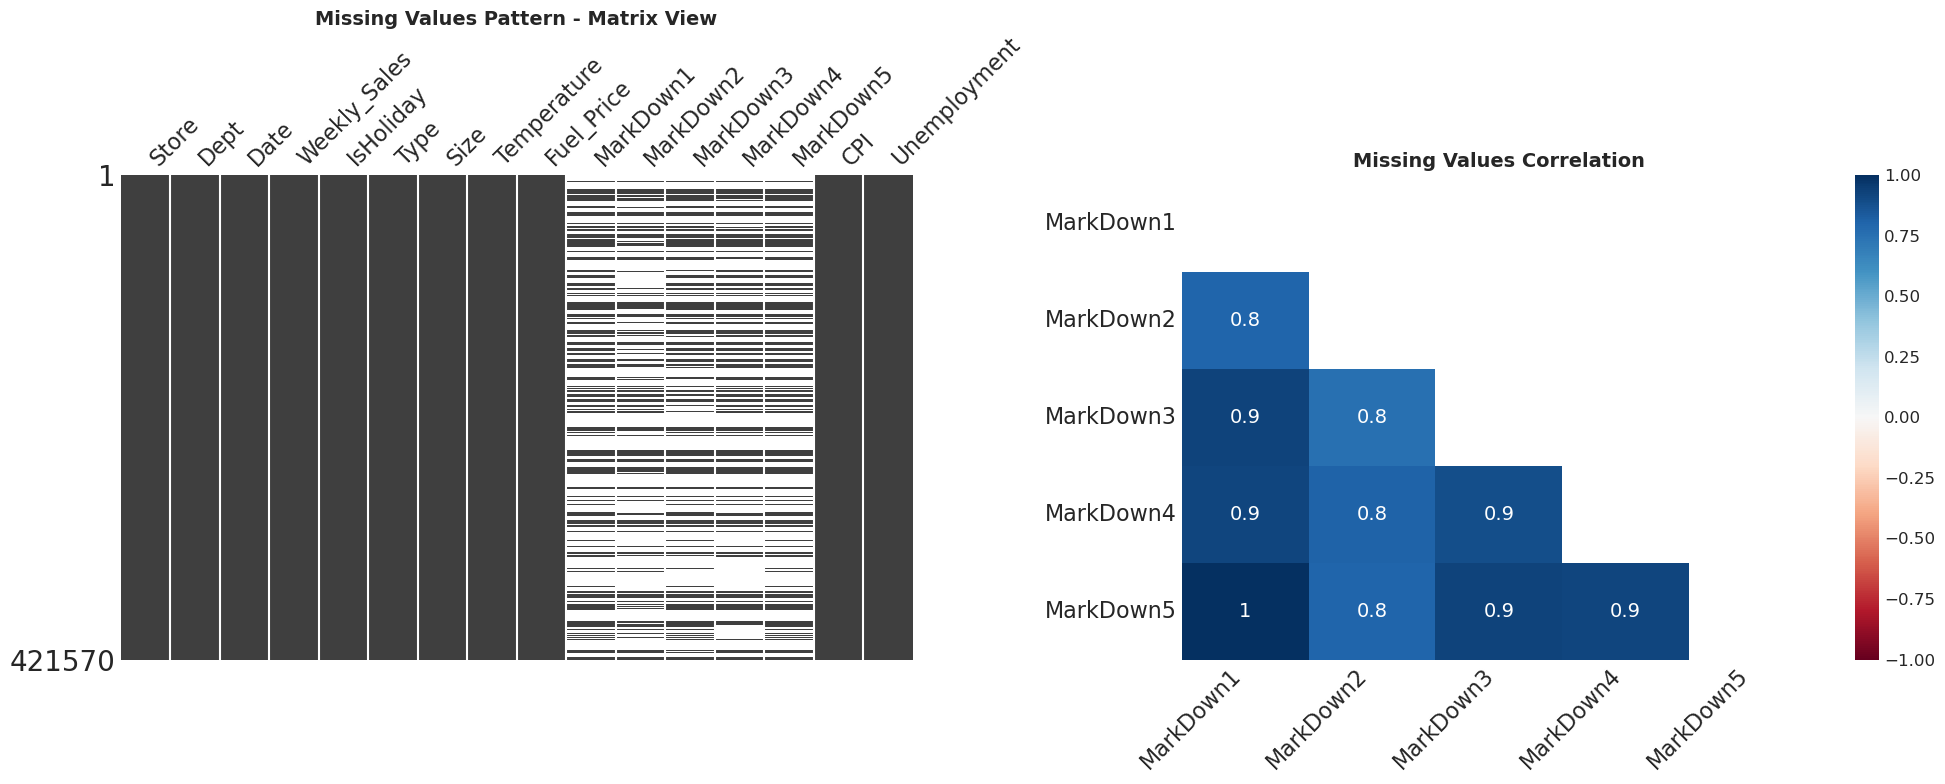

✅ Missing values heatmap saved to ../figures/01_missing_values_analysis.png


In [7]:
# Heatmap missing values
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Heatmap 1: Missing values pattern
msno.matrix(df_merged, ax=axes[0], sparkline=False)
axes[0].set_title('Missing Values Pattern - Matrix View', fontsize=14, fontweight='bold')

# Heatmap 2: Missing values correlation
msno.heatmap(df_merged, ax=axes[1])
axes[1].set_title('Missing Values Correlation', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.savefig('../figures/01_missing_values_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Missing values heatmap saved to ../figures/01_missing_values_analysis.png")


📊 MarkDowns missing rate by month:
   Year  Month  Missing_Rate
0  2010      2           1.0
1  2010      3           1.0
2  2010      4           1.0
3  2010      5           1.0
4  2010      6           1.0
5  2010      7           1.0
6  2010      8           1.0
7  2010      9           1.0
8  2010     10           1.0
9  2010     11           1.0


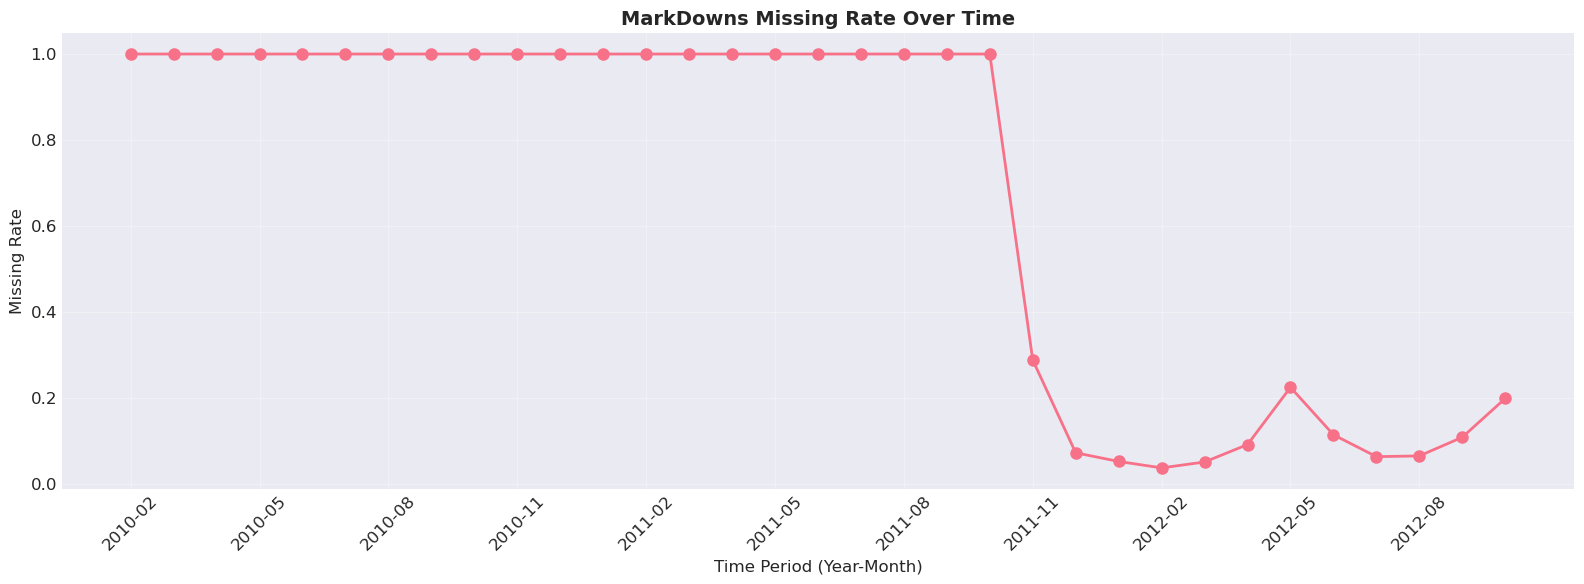

✅ MarkDowns missing pattern saved to ../figures/01_markdowns_missing_over_time.png


In [8]:
# Phân tích pattern missing values theo thời gian (nếu có)
df_merged['Date'] = pd.to_datetime(df_merged['Date'])

# Kiểm tra missing values của MarkDowns theo thời gian
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']
df_merged['Year'] = df_merged['Date'].dt.year
df_merged['Month'] = df_merged['Date'].dt.month

# Missing rate của MarkDowns theo tháng
md_missing_by_month = df_merged.groupby(['Year', 'Month'])[markdown_cols].apply(
    lambda x: x.isnull().sum().sum() / (len(x) * len(markdown_cols))
).reset_index(name='Missing_Rate')

print("📊 MarkDowns missing rate by month:")
print(md_missing_by_month.head(10))

# Visualize
if len(md_missing_by_month) > 0:
    fig, ax = plt.subplots(figsize=(16, 6))
    md_missing_by_month['Year_Month'] = md_missing_by_month['Year'].astype(str) + '-' + md_missing_by_month['Month'].astype(str).str.zfill(2)
    ax.plot(range(len(md_missing_by_month)), md_missing_by_month['Missing_Rate'], marker='o', linewidth=2, markersize=8)
    ax.set_xlabel('Time Period (Year-Month)', fontsize=12)
    ax.set_ylabel('Missing Rate', fontsize=12)
    ax.set_title('MarkDowns Missing Rate Over Time', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(0, len(md_missing_by_month), 3))
    ax.set_xticklabels(md_missing_by_month['Year_Month'].iloc[::3], rotation=45)
    plt.tight_layout()
    plt.savefig('../figures/01_markdowns_missing_over_time.png', dpi=300, bbox_inches='tight')
    plt.show()
    print("✅ MarkDowns missing pattern saved to ../figures/01_markdowns_missing_over_time.png")


### 🔍 Key Findings - Missing Values

- **MarkDowns columns**: Có missing values cao (sẽ fillna(0) trong xử lý)
- **Pattern**: Missing values của MarkDowns có thể theo pattern thời gian (cần kiểm tra)
- **Other columns**: Store, Dept, Date, Weekly_Sales không có missing values

---

## 1.2. Outliers Detection


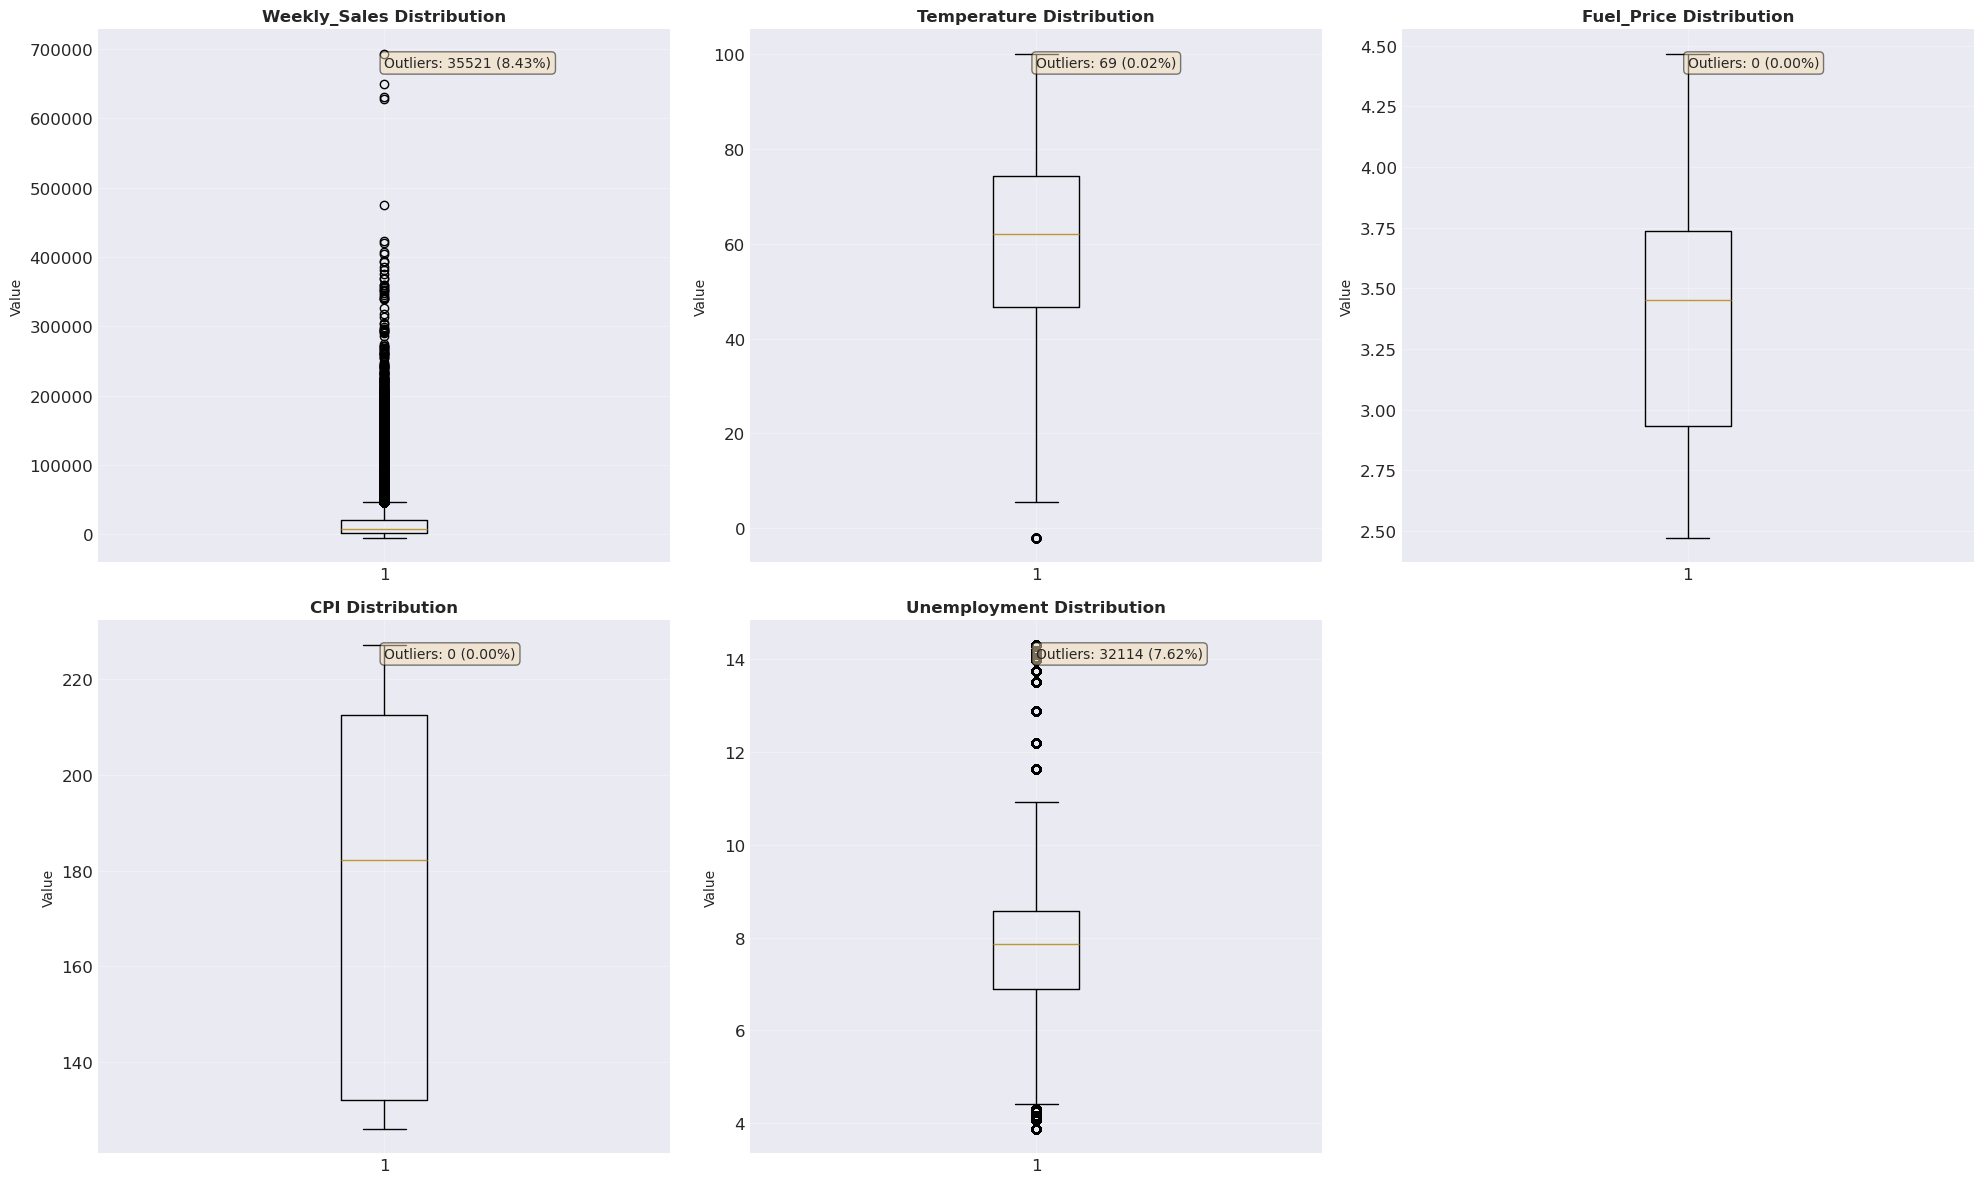

✅ Outliers boxplots saved to ../figures/01_outliers_boxplots.png


In [9]:
# Boxplots cho các numeric columns quan trọng
numeric_cols = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

fig, axes = plt.subplots(2, 3, figsize=(20, 12))
axes = axes.flatten()

for i, col in enumerate(numeric_cols):
    if col in df_merged.columns:
        data = df_merged[col].dropna()
        axes[i].boxplot(data, vert=True)
        axes[i].set_title(f'{col} Distribution', fontsize=12, fontweight='bold')
        axes[i].set_ylabel('Value', fontsize=10)
        axes[i].grid(True, alpha=0.3)
        
        # Thêm statistics
        q1 = data.quantile(0.25)
        q3 = data.quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = data[(data < lower_bound) | (data > upper_bound)]
        
        axes[i].text(0.5, 0.95, f'Outliers: {len(outliers)} ({len(outliers)/len(data)*100:.2f}%)',
                    transform=axes[i].transAxes, fontsize=10,
                    verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Xóa subplot thừa
if len(numeric_cols) < len(axes):
    fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig('../figures/01_outliers_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Outliers boxplots saved to ../figures/01_outliers_boxplots.png")


In [10]:
# Identify outliers bằng IQR method
def identify_outliers_iqr(df, column):
    """Identify outliers using IQR method"""
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

print("📊 Outliers Summary (IQR Method):")
print("="*80)

outliers_summary = []
for col in numeric_cols:
    if col in df_merged.columns:
        outliers, lower, upper = identify_outliers_iqr(df_merged, col)
        outliers_summary.append({
            'Column': col,
            'Outliers Count': len(outliers),
            'Outliers %': len(outliers) / len(df_merged) * 100,
            'Lower Bound': lower,
            'Upper Bound': upper,
            'Min Value': df_merged[col].min(),
            'Max Value': df_merged[col].max()
        })

outliers_df = pd.DataFrame(outliers_summary)
print(outliers_df.to_string(index=False))


📊 Outliers Summary (IQR Method):
      Column  Outliers Count  Outliers %   Lower Bound  Upper Bound  Min Value     Max Value
Weekly_Sales           35521    8.425884 -25109.653750 47395.156250  -4988.940 693099.360000
 Temperature              69    0.016367      5.280000   115.680000     -2.060    100.140000
  Fuel_Price               0    0.000000      1.725500     4.945500      2.472      4.468000
         CPI               0    0.000000     11.431178   333.008482    126.064    227.232807
Unemployment           32114    7.617715      4.369500    11.093500      3.879     14.313000


### 🔍 Key Findings - Outliers

- **Weekly_Sales**: Có outliers (có thể là holiday weeks hoặc special events)
- **Temperature, Fuel_Price, CPI, Unemployment**: Cần kiểm tra outliers có ảnh hưởng đến model không
- **Action**: Có thể cần Winsorization cho extreme values nếu cần

---

## 1.3. Distribution Analysis


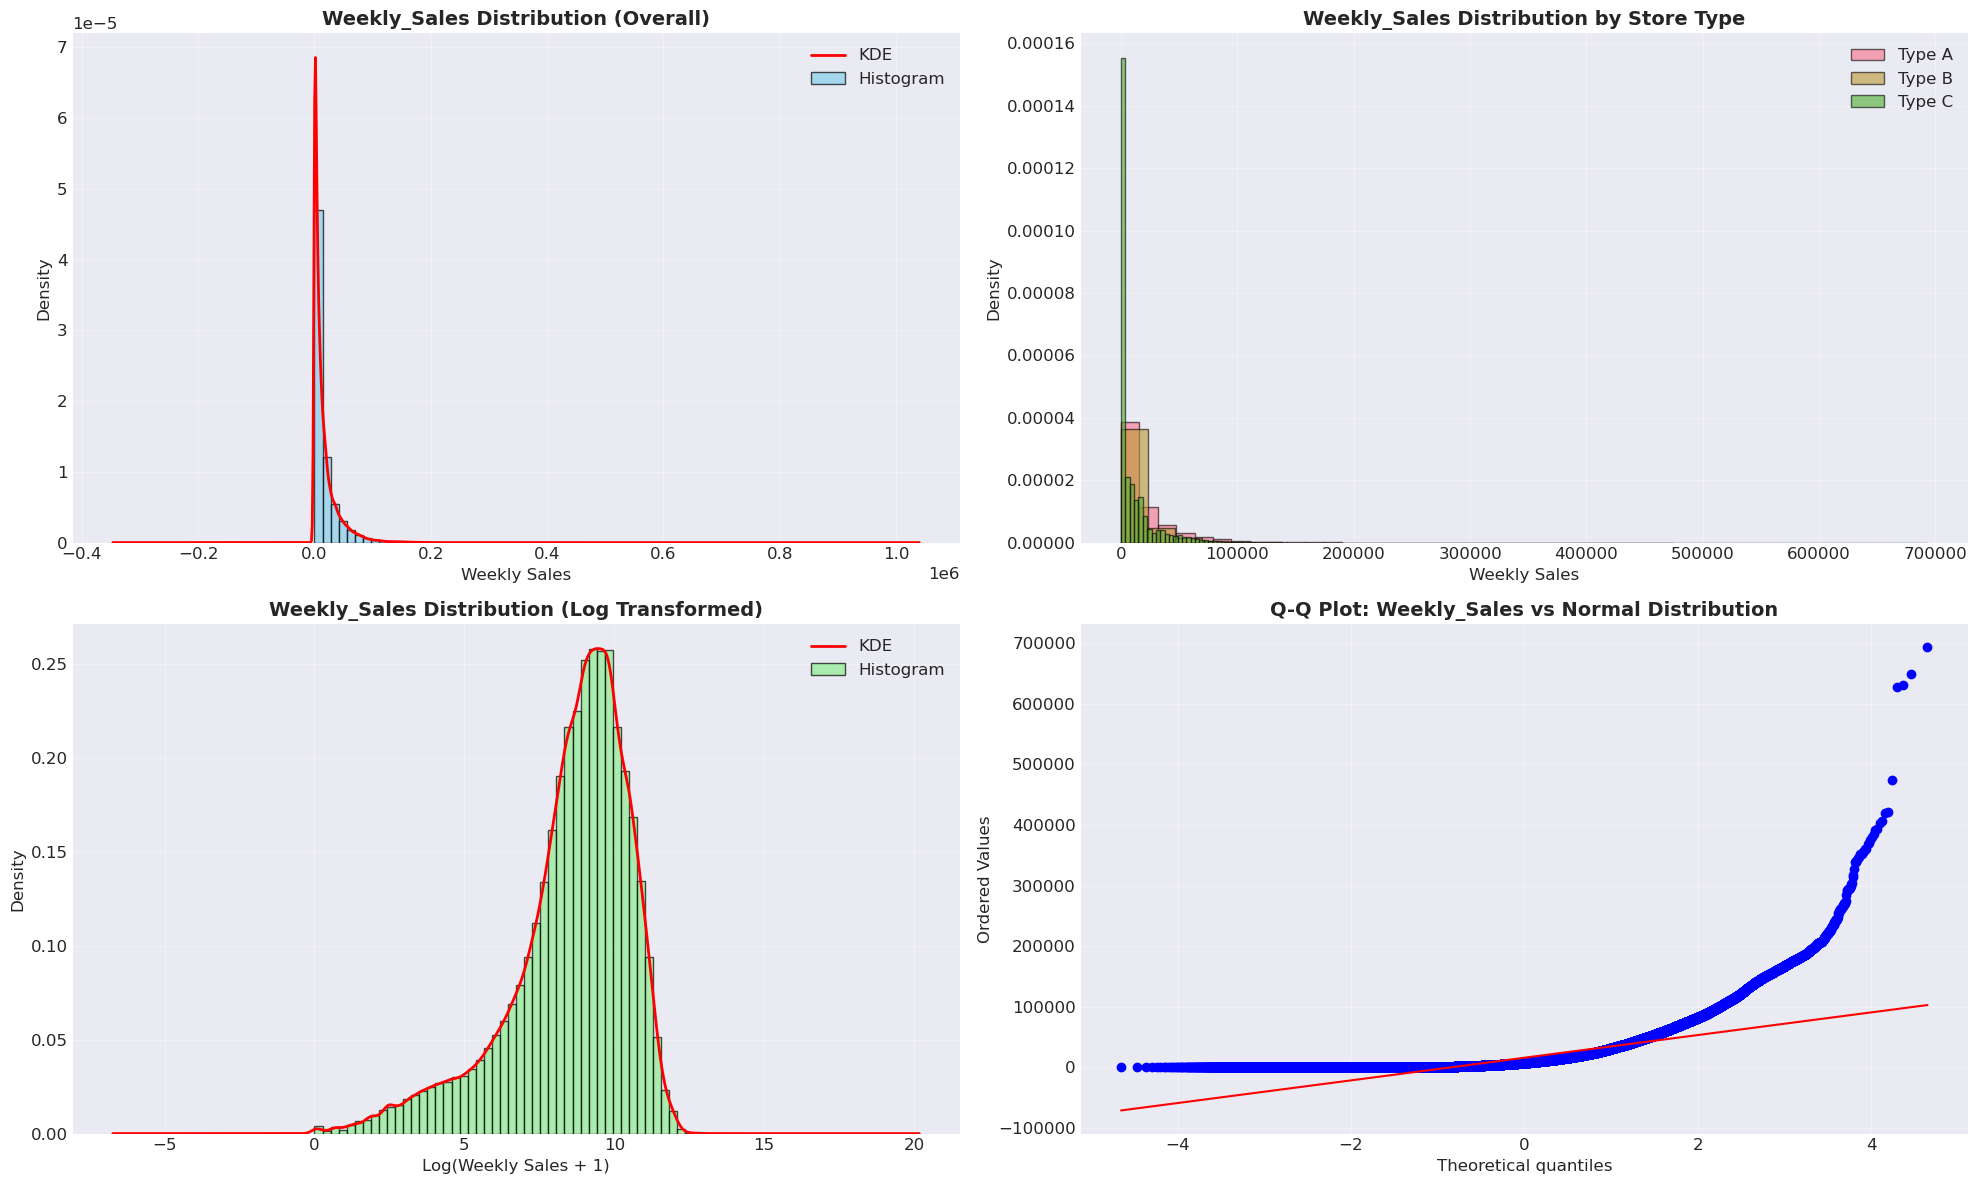

✅ Distribution analysis saved to ../figures/01_distribution_analysis.png


In [11]:
# Histograms + KDE plots cho Weekly_Sales
# Đảm bảo Weekly_Sales >= 0 và không có NaN
df_merged_clean = df_merged[df_merged['Weekly_Sales'].notna() & (df_merged['Weekly_Sales'] >= 0)].copy()

fig, axes = plt.subplots(2, 2, figsize=(20, 12))

# Overall distribution
sales_data = df_merged_clean['Weekly_Sales'].dropna()
axes[0, 0].hist(sales_data, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
sales_data.plot(kind='kde', ax=axes[0, 0], color='red', linewidth=2)
axes[0, 0].set_title('Weekly_Sales Distribution (Overall)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Weekly Sales', fontsize=12)
axes[0, 0].set_ylabel('Density', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(['KDE', 'Histogram'])

# By Store Type
if 'Type' in df_merged_clean.columns:
    for store_type in df_merged_clean['Type'].unique():
        data = df_merged_clean[df_merged_clean['Type'] == store_type]['Weekly_Sales'].dropna()
        if len(data) > 0:
            axes[0, 1].hist(data, bins=30, alpha=0.6, label=f'Type {store_type}', density=True, edgecolor='black')
    axes[0, 1].set_title('Weekly_Sales Distribution by Store Type', fontsize=14, fontweight='bold')
    axes[0, 1].set_xlabel('Weekly Sales', fontsize=12)
    axes[0, 1].set_ylabel('Density', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# Log transformation - chỉ áp dụng cho giá trị >= 0
df_merged_clean['Weekly_Sales_log'] = np.log1p(df_merged_clean['Weekly_Sales'])  # log1p để tránh log(0)
sales_log_data = df_merged_clean['Weekly_Sales_log'].dropna()

# Kiểm tra finite values
sales_log_data = sales_log_data[np.isfinite(sales_log_data)]

if len(sales_log_data) > 0:
    axes[1, 0].hist(sales_log_data, bins=50, density=True, alpha=0.7, color='lightgreen', edgecolor='black')
    sales_log_data.plot(kind='kde', ax=axes[1, 0], color='red', linewidth=2)
    axes[1, 0].set_title('Weekly_Sales Distribution (Log Transformed)', fontsize=14, fontweight='bold')
    axes[1, 0].set_xlabel('Log(Weekly Sales + 1)', fontsize=12)
    axes[1, 0].set_ylabel('Density', fontsize=12)
    axes[1, 0].grid(True, alpha=0.3)
    axes[1, 0].legend(['KDE', 'Histogram'])
else:
    axes[1, 0].text(0.5, 0.5, 'No valid data for log transformation', 
                    ha='center', va='center', transform=axes[1, 0].transAxes, fontsize=12)
    axes[1, 0].set_title('Weekly_Sales Distribution (Log Transformed)', fontsize=14, fontweight='bold')

# QQ-plot để check normality
sales_data_clean = sales_data[np.isfinite(sales_data)]
if len(sales_data_clean) > 0:
    stats.probplot(sales_data_clean, dist="norm", plot=axes[1, 1])
    axes[1, 1].set_title('Q-Q Plot: Weekly_Sales vs Normal Distribution', fontsize=14, fontweight='bold')
    axes[1, 1].grid(True, alpha=0.3)
else:
    axes[1, 1].text(0.5, 0.5, 'No valid data for Q-Q plot', 
                    ha='center', va='center', transform=axes[1, 1].transAxes, fontsize=12)

plt.tight_layout()
plt.savefig('../figures/01_distribution_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Distribution analysis saved to ../figures/01_distribution_analysis.png")


In [12]:
# Normality test
print("📊 Normality Tests:")
print("="*80)

# D'Agostino and Pearson's test
stat, p_value = normaltest(df_merged['Weekly_Sales'].dropna())
print(f"D'Agostino-Pearson Test:")
print(f"  Statistic: {stat:.4f}")
print(f"  p-value: {p_value:.4e}")
print(f"  Normal distribution: {'Yes' if p_value > 0.05 else 'No'}")

# Skewness and Kurtosis
from scipy.stats import skew, kurtosis
skewness = skew(df_merged['Weekly_Sales'].dropna())
kurt = kurtosis(df_merged['Weekly_Sales'].dropna())

print(f"\nSkewness: {skewness:.4f} (Normal = 0)")
print(f"Kurtosis: {kurt:.4f} (Normal = 3)")

if abs(skewness) > 1:
    print("⚠️ Data is highly skewed - log transformation recommended")
else:
    print("✅ Data is approximately symmetric")


📊 Normality Tests:
D'Agostino-Pearson Test:
  Statistic: 310589.5860
  p-value: 0.0000e+00
  Normal distribution: No

Skewness: 3.2620 (Normal = 0)
Kurtosis: 21.4910 (Normal = 3)
⚠️ Data is highly skewed - log transformation recommended


### 🔍 Key Findings - Distribution

- **Weekly_Sales**: Right-skewed distribution (có thể cần log transformation)
- **Store Type differences**: Các store type có distribution khác nhau
- **Normality**: Data không follow normal distribution (expected cho sales data)

---

## 1.4. Initial Correlation Analysis


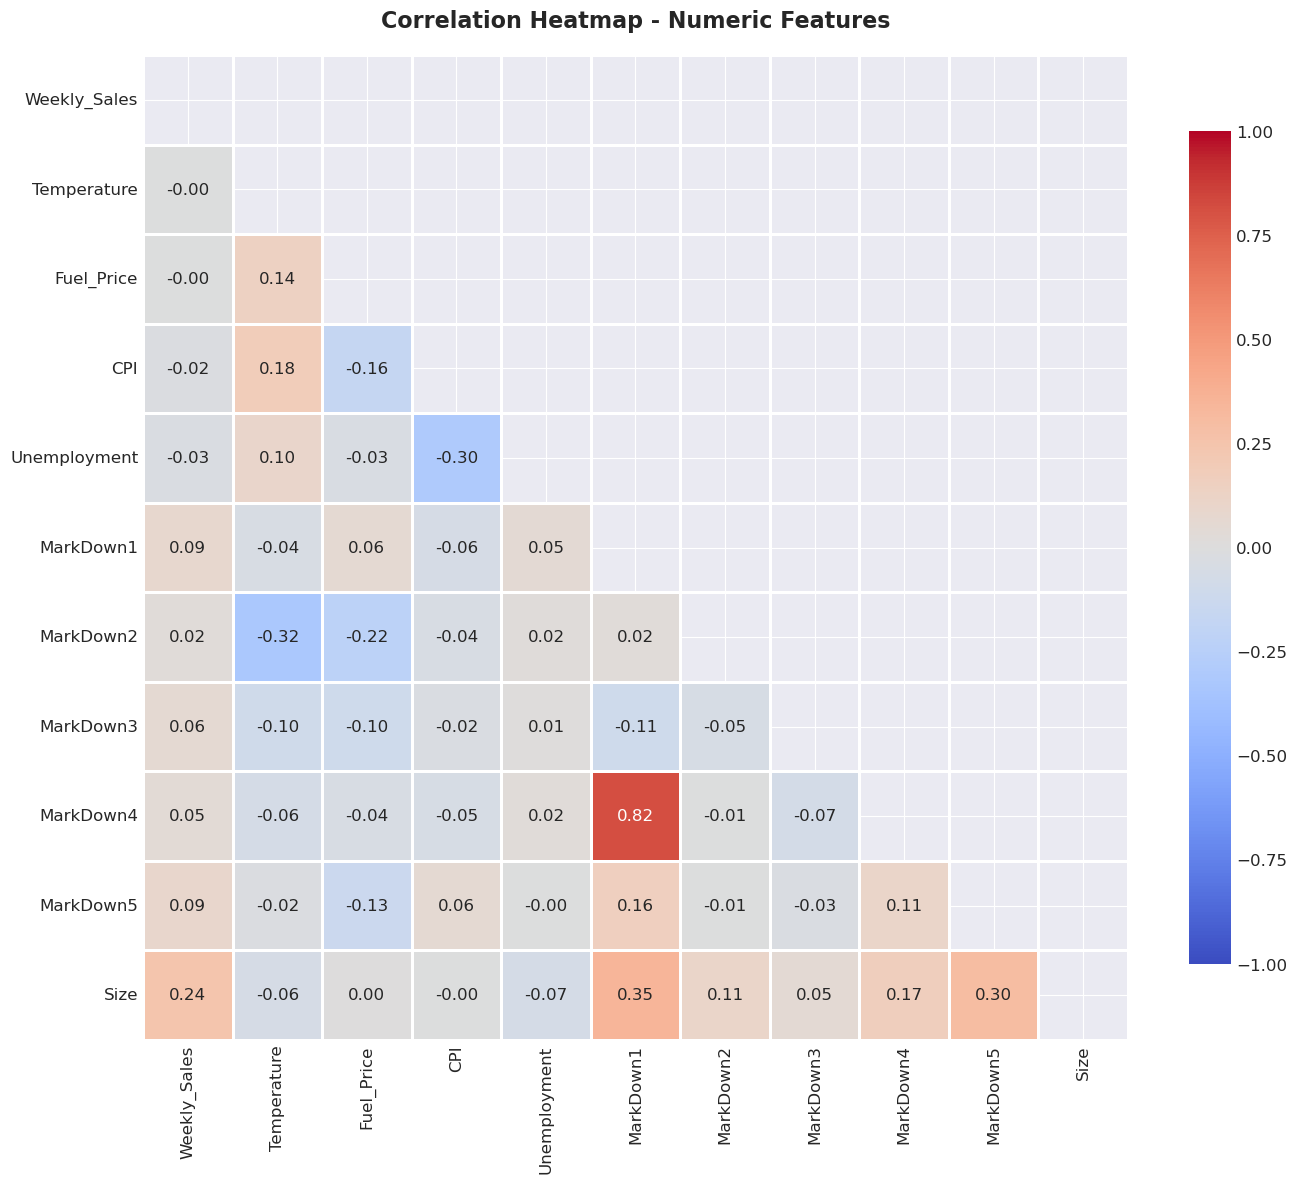

✅ Correlation heatmap saved to ../figures/01_correlation_heatmap.png


In [13]:
# Correlation heatmap cho numeric features gốc
numeric_features = ['Weekly_Sales', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 
                    'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5', 'Size']

# Chỉ lấy các cột có trong dataframe
numeric_features = [col for col in numeric_features if col in df_merged.columns]

corr_matrix = df_merged[numeric_features].corr()

# Create heatmap
fig, ax = plt.subplots(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
            center=0, square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax,
            vmin=-1, vmax=1)
ax.set_title('Correlation Heatmap - Numeric Features', fontsize=16, fontweight='bold', pad=20)
plt.tight_layout()
plt.savefig('../figures/01_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Correlation heatmap saved to ../figures/01_correlation_heatmap.png")


In [14]:
# Highlight strong correlations (>0.7 hoặc <-0.7)
print("📊 Strong Correlations (|r| > 0.7):")
print("="*80)

strong_corr = []
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        corr_val = corr_matrix.iloc[i, j]
        if abs(corr_val) > 0.7:
            strong_corr.append({
                'Feature 1': corr_matrix.columns[i],
                'Feature 2': corr_matrix.columns[j],
                'Correlation': corr_val
            })

if strong_corr:
    strong_corr_df = pd.DataFrame(strong_corr)
    print(strong_corr_df.to_string(index=False))
    print("\n⚠️ Warning: High correlation detected - potential multicollinearity!")
else:
    print("✅ No strong correlations found (|r| > 0.7)")

# Correlation với Weekly_Sales
print(f"\n📊 Correlation with Weekly_Sales:")
print("="*80)
sales_corr = corr_matrix['Weekly_Sales'].sort_values(ascending=False)
print(sales_corr.to_string())


📊 Strong Correlations (|r| > 0.7):
Feature 1 Feature 2  Correlation
MarkDown1 MarkDown4     0.819238

⚠️ Warning: High correlation detected - potential multicollinearity!

📊 Correlation with Weekly_Sales:
Weekly_Sales    1.000000
Size            0.243828
MarkDown5       0.090362
MarkDown1       0.085251
MarkDown3       0.060385
MarkDown4       0.045414
MarkDown2       0.024130
Fuel_Price     -0.000120
Temperature    -0.002312
CPI            -0.020921
Unemployment   -0.025864


### 🔍 Key Findings - Correlation

- **Strong correlations**: Cần kiểm tra multicollinearity (đặc biệt giữa MarkDowns)
- **Weekly_Sales correlations**: Xem features nào có correlation cao nhất với target
- **Action**: Có thể cần feature selection hoặc dimensionality reduction

---

## ✅ What we just did

1. **Missing Values Analysis**: Phát hiện pattern missing của MarkDowns
2. **Outliers Detection**: Xác định outliers bằng IQR method
3. **Distribution Analysis**: Phân tích phân phối và normality
4. **Correlation Analysis**: Tìm strong correlations và potential multicollinearity

## ⚠️ Assumptions/Limitations

- Missing values của MarkDowns sẽ được fillna(0) - giả định "không có giảm giá"
- Outliers có thể là legitimate (holiday weeks) - cần xem xét kỹ trước khi remove
- Correlation analysis chỉ trên numeric features gốc - sẽ có thêm engineered features sau

---


---

# GIAI ĐOẠN 1: CHUẨN BỊ DỮ LIỆU

## 1.1. Tạo df_main_weekly

**Mục tiêu:**
- Merge 3 files: train.csv, stores.csv, features.csv
- Xử lý MarkDowns (fillna, tạo features)
- Xử lý Weekly_Sales âm (returns)
- Validation dữ liệu


In [15]:
# Load các datasets
print("🔄 Loading datasets...")
train_df = pd.read_csv(DATA_PATH + 'train.csv')
stores_df = pd.read_csv(DATA_PATH + 'stores.csv')
features_df = pd.read_csv(DATA_PATH + 'features.csv')

print(f"📈 Train data shape: {train_df.shape}")
print(f"🏪 Stores data shape: {stores_df.shape}")
print(f"🌡️ Features data shape: {features_df.shape}")


🔄 Loading datasets...
📈 Train data shape: (421570, 5)
🏪 Stores data shape: (45, 3)
🌡️ Features data shape: (8190, 12)


In [16]:
# Merge 3 files
print("🔄 Merging datasets...")
df_main = pd.merge(train_df, stores_df, on='Store', how='left')
df_main = pd.merge(df_main, features_df, on=['Store', 'Date'], how='left', suffixes=('', '_features'))

# Xử lý duplicate IsHoliday columns
if 'IsHoliday_features' in df_main.columns:
    df_main = df_main.drop(columns=['IsHoliday_features'])

print(f"✅ Merged data shape: {df_main.shape}")
print(f"\nSample data:")
df_main.head()


🔄 Merging datasets...
✅ Merged data shape: (421570, 16)

Sample data:


,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [17]:
# Chuyển đổi Date sang datetime và đổi tên thành WeekEndDate
df_main['Date'] = pd.to_datetime(df_main['Date'])
df_main = df_main.rename(columns={'Date': 'WeekEndDate'})

print(f"📅 Time range: {df_main['WeekEndDate'].min()} to {df_main['WeekEndDate'].max()}")

# Kiểm tra WeekEndDate có phải là Thứ Sáu không
df_main['WeekDay'] = df_main['WeekEndDate'].dt.day_name()
print(f"\nWeekday distribution:")
print(df_main['WeekDay'].value_counts())


📅 Time range: 2010-02-05 00:00:00 to 2012-10-26 00:00:00

Weekday distribution:
WeekDay
Friday    421570
Name: count, dtype: int64


In [18]:
# Xử lý MarkDowns
markdown_cols = ['MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

# Fill NA với 0
for col in markdown_cols:
    df_main[col] = df_main[col].fillna(0)

# Tạo md_missing_any: = 1 nếu cả 5 cột đều là 0
df_main['md_missing_any'] = ((df_main[markdown_cols] == 0).all(axis=1)).astype(int)

# Tạo md_sum: Tổng giá trị của 5 cột MarkDown
df_main['md_sum'] = df_main[markdown_cols].sum(axis=1)

print(f"📊 MarkDowns missing (all zeros): {df_main['md_missing_any'].sum()} records")
print(f"\nMarkDowns sum statistics:")
print(df_main['md_sum'].describe())


📊 MarkDowns missing (all zeros): 270138 records

MarkDowns sum statistics:
count    421570.000000
mean       6684.041435
std       14750.941552
min           0.000000
25%           0.000000
50%           0.000000
75%        8075.260000
max      160510.610000
Name: md_sum, dtype: float64


In [19]:
# Xử lý Weekly_Sales âm
# Tạo returns_flag và returns_abs trước khi clip
df_main['returns_flag'] = (df_main['Weekly_Sales'] < 0).astype(int)
df_main['returns_abs'] = df_main['Weekly_Sales'].apply(lambda x: abs(x) if x < 0 else 0)

print(f"📊 Negative sales processed: {df_main['returns_flag'].sum()} records")
print(f"📊 Total returns value: ${df_main['returns_abs'].sum():,.2f}")

# Clip Weekly_Sales về >= 0
df_main['Weekly_Sales'] = df_main['Weekly_Sales'].clip(lower=0)

print(f"✅ All Weekly_Sales are now >= 0")


📊 Negative sales processed: 1285 records
📊 Total returns value: $88,161.56
✅ All Weekly_Sales are now >= 0


In [20]:
# Validation
print("🔍 Validating data quality...")

# Kiểm tra WeekEndDate không bị NA
assert df_main['WeekEndDate'].notna().all(), "WeekEndDate has NA!"

# Kiểm tra Store và Dept không bị NA
assert df_main['Store'].notna().all(), "Store has NA!"
assert df_main['Dept'].notna().all(), "Dept has NA!"

# Kiểm tra Weekly_Sales (sau clip) không âm
assert (df_main['Weekly_Sales'] >= 0).all(), "Weekly_Sales still negative!"

print("✅ All validations passed!")

# Lưu df_main_weekly
df_main_weekly = df_main.copy()
print(f"\n📊 df_main_weekly created! Shape: {df_main_weekly.shape}")
print(f"📊 Columns: {len(df_main_weekly.columns)}")


🔍 Validating data quality...
✅ All validations passed!

📊 df_main_weekly created! Shape: (421570, 21)
📊 Columns: 21


## 1.2. Tạo df_events_daily

**Mục tiêu:**
- Tạo lịch daily từ min_date đến max_date
- Thêm features Payday (SNAP, semimonthly, tax refund)
- Tạo lịch Holiday events cho Mỹ (2010-2012)


In [21]:
# Tạo lịch daily từ min_date đến max_date
min_date = df_main_weekly['WeekEndDate'].min()
max_date = df_main_weekly['WeekEndDate'].max()

date_range = pd.date_range(start=min_date, end=max_date, freq='D')
df_events_daily = pd.DataFrame({'Date': date_range})

print(f"📅 Date range: {min_date.date()} to {max_date.date()}")
print(f"📅 Total days: {len(df_events_daily)}")


📅 Date range: 2010-02-05 to 2012-10-26
📅 Total days: 995


In [22]:
# Thêm features Payday
# is_snap_window_1: ngày 1-10
df_events_daily['is_snap_window_1'] = (df_events_daily['Date'].dt.day <= 10).astype(int)

# is_snap_window_2: ngày 11-20
df_events_daily['is_snap_window_2'] = ((df_events_daily['Date'].dt.day >= 11) & 
                                       (df_events_daily['Date'].dt.day <= 20)).astype(int)

# is_semimonthly_payday: ngày 15 hoặc cuối tháng
df_events_daily['is_semimonthly_payday'] = ((df_events_daily['Date'].dt.day == 15) | 
                                           (df_events_daily['Date'].dt.is_month_end)).astype(int)

# is_tax_refund_season: 15/02 - 15/04 hàng năm
df_events_daily['is_tax_refund_season'] = df_events_daily['Date'].apply(is_tax_refund_season)

print("✅ Payday features added!")
print(f"   SNAP window 1 days: {df_events_daily['is_snap_window_1'].sum()}")
print(f"   SNAP window 2 days: {df_events_daily['is_snap_window_2'].sum()}")
print(f"   Semimonthly payday days: {df_events_daily['is_semimonthly_payday'].sum()}")
print(f"   Tax refund season days: {df_events_daily['is_tax_refund_season'].sum()}")


✅ Payday features added!
   SNAP window 1 days: 326
   SNAP window 2 days: 330
   Semimonthly payday days: 65
   Tax refund season days: 181


In [23]:
# Tạo lịch Holiday events cho Mỹ (2010-2012)
all_holidays = {}
for year in [2010, 2011, 2012]:
    all_holidays.update(get_us_holidays(year))

# Map vào df_events_daily
df_events_daily['HolidayName'] = df_events_daily['Date'].dt.strftime('%Y-%m-%d').map(
    lambda x: all_holidays.get(x, ('', 0))[0] if x in all_holidays else ''
)
df_events_daily['holiday_impact'] = df_events_daily['Date'].dt.strftime('%Y-%m-%d').map(
    lambda x: all_holidays.get(x, ('', 0))[1] if x in all_holidays else 0
)

print("✅ Holiday events added!")
print(f"   Total holidays: {(df_events_daily['HolidayName'] != '').sum()}")
print(f"\nHoliday distribution:")
print(df_events_daily[df_events_daily['HolidayName'] != '']['HolidayName'].value_counts())


✅ Holiday events added!
   Total holidays: 23

Holiday distribution:
HolidayName
Super Bowl          3
Presidents Day      3
Memorial Day        3
Independence Day    3
Labor Day           3
Thanksgiving        2
Christmas Eve       2
Christmas           2
New Years Day       2
Name: count, dtype: int64


In [24]:
# Xem sample df_events_daily
print("📊 df_events_daily shape:", df_events_daily.shape)
print("\nSample data:")
df_events_daily.head(15)


📊 df_events_daily shape: (995, 7)

Sample data:


,Date,is_snap_window_1,is_snap_window_2,is_semimonthly_payday,is_tax_refund_season,HolidayName,holiday_impact
0,2010-02-05,1,0,0,0,,0
1,2010-02-06,1,0,0,0,,0
2,2010-02-07,1,0,0,0,Super Bowl,3
3,2010-02-08,1,0,0,0,,0
4,2010-02-09,1,0,0,0,,0
5,2010-02-10,1,0,0,0,,0
6,2010-02-11,0,1,0,0,,0
7,2010-02-12,0,1,0,0,,0
8,2010-02-13,0,1,0,0,,0
9,2010-02-14,0,1,0,0,,0


## 1.3. Tạo df_feature_calendar_weekly

**Mục tiêu:**
- Thêm WeekEndDate vào df_events_daily
- Groupby WeekEndDate và aggregate các features


In [25]:
# Thêm WeekEndDate vào df_events_daily
df_events_daily['WeekEndDate'] = df_events_daily['Date'].apply(get_week_end_date)

print("✅ WeekEndDate added to df_events_daily!")
print(f"\nSample WeekEndDate mapping:")
print(df_events_daily[['Date', 'WeekEndDate']].head(10))


✅ WeekEndDate added to df_events_daily!

Sample WeekEndDate mapping:
        Date WeekEndDate
0 2010-02-05  2010-02-05
1 2010-02-06  2010-02-12
2 2010-02-07  2010-02-12
3 2010-02-08  2010-02-12
4 2010-02-09  2010-02-12
5 2010-02-10  2010-02-12
6 2010-02-11  2010-02-12
7 2010-02-12  2010-02-12
8 2010-02-13  2010-02-19
9 2010-02-14  2010-02-19


In [26]:
# Groupby WeekEndDate và aggregate
df_feature_calendar_weekly = df_events_daily.groupby('WeekEndDate').agg({
    'is_snap_window_1': lambda x: 1 if x.sum() > 0 else 0,
    'is_snap_window_2': lambda x: 1 if x.sum() > 0 else 0,
    'is_semimonthly_payday': lambda x: 1 if x.sum() > 0 else 0,
    'is_tax_refund_season': lambda x: 1 if x.sum() > 0 else 0,
    'holiday_impact': 'max',
    'HolidayName': lambda x: x[x != ''].iloc[0] if (x != '').any() else ''
}).reset_index()

# Đổi tên cột
df_feature_calendar_weekly = df_feature_calendar_weekly.rename(columns={
    'is_snap_window_1': 'is_snap_window_1_week',
    'is_snap_window_2': 'is_snap_window_2_week',
    'is_semimonthly_payday': 'is_semimonthly_payweek',
    'is_tax_refund_season': 'is_tax_refund_season_week',
    'holiday_impact': 'holiday_impact_week',
    'HolidayName': 'holiday_name_week'
})

print(f"✅ df_feature_calendar_weekly created! Shape: {df_feature_calendar_weekly.shape}")
print(f"\nSample data:")
df_feature_calendar_weekly.head(10)


✅ df_feature_calendar_weekly created! Shape: (143, 7)

Sample data:


,WeekEndDate,is_snap_window_1_week,is_snap_window_2_week,is_semimonthly_payweek,is_tax_refund_season_week,holiday_impact_week,holiday_name_week
0,2010-02-05,1,0,0,0,0,
1,2010-02-12,1,1,0,0,3,Super Bowl
2,2010-02-19,0,1,1,1,1,Presidents Day
3,2010-02-26,0,1,0,1,0,
4,2010-03-05,1,0,1,1,0,
5,2010-03-12,1,1,0,1,0,
6,2010-03-19,0,1,1,1,0,
7,2010-03-26,0,1,0,1,0,
8,2010-04-02,1,0,1,1,0,
9,2010-04-09,1,0,0,1,0,


In [27]:
# Xem statistics của weekly features
print("📊 Weekly features statistics:")
print(f"\n   SNAP window 1 weeks: {df_feature_calendar_weekly['is_snap_window_1_week'].sum()}")
print(f"   SNAP window 2 weeks: {df_feature_calendar_weekly['is_snap_window_2_week'].sum()}")
print(f"   Semimonthly payweeks: {df_feature_calendar_weekly['is_semimonthly_payweek'].sum()}")
print(f"   Tax refund season weeks: {df_feature_calendar_weekly['is_tax_refund_season_week'].sum()}")
print(f"   Weeks with holidays: {(df_feature_calendar_weekly['holiday_name_week'] != '').sum()}")


📊 Weekly features statistics:

   SNAP window 1 weeks: 75
   SNAP window 2 weeks: 76
   Semimonthly payweeks: 65
   Tax refund season weeks: 28
   Weeks with holidays: 22


---

# 📈 SECTION 2: EXPLORATORY DATA ANALYSIS

**Mục tiêu:** Phân tích sâu các patterns và relationships trong dữ liệu sau khi feature engineering.

## 2.1. Temporal Patterns Analysis

### A. Overall Sales Trend


In [28]:
# Time series plot: Weekly_Sales over time (aggregate toàn bộ stores)
# Sử dụng df_final đã có từ feature engineering

# Aggregate sales theo WeekEndDate
sales_by_week = df_final.groupby('WeekEndDate')['Weekly_Sales'].agg(['sum', 'mean', 'std']).reset_index()
sales_by_week.columns = ['WeekEndDate', 'Total_Sales', 'Mean_Sales', 'Std_Sales']

# Tính moving average
sales_by_week['MA_4_weeks'] = sales_by_week['Total_Sales'].rolling(window=4, min_periods=1).mean()
sales_by_week['MA_12_weeks'] = sales_by_week['Total_Sales'].rolling(window=12, min_periods=1).mean()

# Identify major events
sales_by_week['Year'] = sales_by_week['WeekEndDate'].dt.year
sales_by_week['Month'] = sales_by_week['WeekEndDate'].dt.month
sales_by_week['IsThanksgiving'] = sales_by_week['Month'].eq(11) & sales_by_week['WeekEndDate'].dt.day.between(20, 30)
sales_by_week['IsChristmas'] = sales_by_week['Month'].eq(12)
sales_by_week['IsTaxSeason'] = sales_by_week['Month'].between(2, 4)

# Plot
fig, ax = plt.subplots(figsize=(20, 8))
ax.plot(sales_by_week['WeekEndDate'], sales_by_week['Total_Sales'], 
        label='Total Weekly Sales', alpha=0.6, linewidth=1.5, color='steelblue')
ax.plot(sales_by_week['WeekEndDate'], sales_by_week['MA_4_weeks'], 
        label='4-Week Moving Average', linewidth=2, color='orange')
ax.plot(sales_by_week['WeekEndDate'], sales_by_week['MA_12_weeks'], 
        label='12-Week Moving Average', linewidth=2, color='red')

# Highlight major events
thanksgiving_weeks = sales_by_week[sales_by_week['IsThanksgiving']]
christmas_weeks = sales_by_week[sales_by_week['IsChristmas']]
tax_weeks = sales_by_week[sales_by_week['IsTaxSeason']]

ax.scatter(thanksgiving_weeks['WeekEndDate'], thanksgiving_weeks['Total_Sales'], 
          color='gold', s=100, marker='*', label='Thanksgiving', zorder=5)
ax.scatter(christmas_weeks['WeekEndDate'], christmas_weeks['Total_Sales'], 
          color='red', s=100, marker='*', label='Christmas', zorder=5)
ax.scatter(tax_weeks['WeekEndDate'], tax_weeks['Total_Sales'], 
          color='green', s=50, marker='o', alpha=0.3, label='Tax Season', zorder=4)

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Total Weekly Sales ($)', fontsize=12)
ax.set_title('Overall Sales Trend with Major Events', fontsize=16, fontweight='bold')
ax.legend(loc='best', fontsize=10)
ax.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('../figures/02_sales_trend_overall.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Sales trend plot saved to ../figures/02_sales_trend_overall.png")


NameError: name 'df_final' is not defined

### B. Seasonal Decomposition


In [ ]:
# Decompose sales thành: Trend + Seasonal + Residual
from statsmodels.tsa.seasonal import seasonal_decompose

# Prepare time series data (weekly frequency)
ts_data = sales_by_week.set_index('WeekEndDate')['Total_Sales']

# Seasonal decomposition (52 weeks = 1 year)
decomposition = seasonal_decompose(ts_data, model='additive', period=52, extrapolate_trend='freq')

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(20, 12))
fig.suptitle('Seasonal Decomposition of Weekly Sales', fontsize=16, fontweight='bold', y=0.995)

decomposition.observed.plot(ax=axes[0], color='steelblue', linewidth=1.5)
axes[0].set_title('Observed', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Sales ($)', fontsize=10)
axes[0].grid(True, alpha=0.3)

decomposition.trend.plot(ax=axes[1], color='orange', linewidth=2)
axes[1].set_title('Trend', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Sales ($)', fontsize=10)
axes[1].grid(True, alpha=0.3)

decomposition.seasonal.plot(ax=axes[2], color='green', linewidth=1.5)
axes[2].set_title('Seasonal', fontsize=12, fontweight='bold')
axes[2].set_ylabel('Sales ($)', fontsize=10)
axes[2].grid(True, alpha=0.3)

decomposition.resid.plot(ax=axes[3], color='red', linewidth=1, alpha=0.7)
axes[3].set_title('Residual', fontsize=12, fontweight='bold')
axes[3].set_ylabel('Sales ($)', fontsize=10)
axes[3].set_xlabel('Date', fontsize=10)
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../figures/02_seasonal_decomposition.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Seasonal decomposition saved to ../figures/02_seasonal_decomposition.png")
print(f"\n📊 Decomposition Statistics:")
print(f"  Trend range: ${decomposition.trend.min():,.0f} - ${decomposition.trend.max():,.0f}")
print(f"  Seasonal range: ${decomposition.seasonal.min():,.0f} - ${decomposition.seasonal.max():,.0f}")
print(f"  Residual std: ${decomposition.resid.std():,.0f}")


### C. Year-over-Year Comparison


In [ ]:
# Plot sales theo month, split by year (2010, 2011, 2012)
df_final['Year'] = df_final['WeekEndDate'].dt.year
df_final['Month'] = df_final['WeekEndDate'].dt.month

monthly_sales = df_final.groupby(['Year', 'Month'])['Weekly_Sales'].agg(['sum', 'mean']).reset_index()
monthly_sales.columns = ['Year', 'Month', 'Total_Sales', 'Mean_Sales']

# Calculate YoY growth rates
monthly_sales_pivot = monthly_sales.pivot(index='Month', columns='Year', values='Total_Sales')
monthly_sales_pivot['YoY_Growth_2011'] = ((monthly_sales_pivot[2011] - monthly_sales_pivot[2010]) / monthly_sales_pivot[2010] * 100)
monthly_sales_pivot['YoY_Growth_2012'] = ((monthly_sales_pivot[2012] - monthly_sales_pivot[2011]) / monthly_sales_pivot[2011] * 100)

# Plot
fig, axes = plt.subplots(2, 1, figsize=(16, 12))

# Plot 1: Monthly sales by year
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
x = np.arange(len(month_names))
width = 0.25

axes[0].bar(x - width, monthly_sales_pivot[2010], width, label='2010', color='steelblue', alpha=0.8)
axes[0].bar(x, monthly_sales_pivot[2011], width, label='2011', color='orange', alpha=0.8)
axes[0].bar(x + width, monthly_sales_pivot[2012], width, label='2012', color='green', alpha=0.8)

axes[0].set_xlabel('Month', fontsize=12)
axes[0].set_ylabel('Total Monthly Sales ($)', fontsize=12)
axes[0].set_title('Monthly Sales by Year', fontsize=14, fontweight='bold')
axes[0].set_xticks(x)
axes[0].set_xticklabels(month_names)
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: YoY growth rates
axes[1].plot(month_names, monthly_sales_pivot['YoY_Growth_2011'], 
            marker='o', linewidth=2, label='2011 vs 2010', color='orange')
axes[1].plot(month_names, monthly_sales_pivot['YoY_Growth_2012'], 
            marker='s', linewidth=2, label='2012 vs 2011', color='green')
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

axes[1].set_xlabel('Month', fontsize=12)
axes[1].set_ylabel('YoY Growth Rate (%)', fontsize=12)
axes[1].set_title('Year-over-Year Growth Rates', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].set_xticklabels(month_names, rotation=45)

plt.tight_layout()
plt.savefig('../figures/02_yoy_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ YoY comparison saved to ../figures/02_yoy_comparison.png")
print(f"\n📊 Average YoY Growth:")
print(f"  2011 vs 2010: {monthly_sales_pivot['YoY_Growth_2011'].mean():.2f}%")
print(f"  2012 vs 2011: {monthly_sales_pivot['YoY_Growth_2012'].mean():.2f}%")


### 🔍 Key Findings - Temporal Patterns

- **Overall Trend**: Sales có xu hướng tăng theo thời gian (trend component)
- **Seasonality**: Có pattern mùa vụ rõ ràng (52-week cycle)
- **Major Events**: Thanksgiving và Christmas có impact lớn
- **YoY Growth**: Cần kiểm tra growth rates có consistent không

---

## 2.2. Payday Pulse Analysis ⭐ QUAN TRỌNG

### A. SNAP Window Impact


In [ ]:
# Bar chart: Average sales SNAP week vs Non-SNAP week
# Breakdown by Store Type (A, B, C)

snap_analysis = df_final.groupby(['is_snap_window_1_week', 'Type'])['Weekly_Sales'].agg(['mean', 'count']).reset_index()
snap_analysis.columns = ['Is_SNAP', 'Type', 'Mean_Sales', 'Count']

# Calculate lift percentage
non_snap_sales = df_final[df_final['is_snap_window_1_week'] == 0].groupby('Type')['Weekly_Sales'].mean()
snap_sales = df_final[df_final['is_snap_window_1_week'] == 1].groupby('Type')['Weekly_Sales'].mean()
lift = ((snap_sales - non_snap_sales) / non_snap_sales * 100).reset_index()
lift.columns = ['Type', 'Lift_%']

# Plot
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot 1: Average sales by SNAP and Store Type
x = np.arange(len(snap_analysis['Type'].unique()))
width = 0.35

for i, snap in enumerate([0, 1]):
    data = snap_analysis[snap_analysis['Is_SNAP'] == snap]
    label = 'Non-SNAP Week' if snap == 0 else 'SNAP Week'
    color = 'steelblue' if snap == 0 else 'orange'
    axes[0].bar(x + i*width, data['Mean_Sales'], width, label=label, color=color, alpha=0.8)
    
    # Add count annotations
    for j, (idx, row) in enumerate(data.iterrows()):
        axes[0].text(x[j] + i*width, row['Mean_Sales'] + 1000, 
                    f'n={int(row["Count"])}', ha='center', va='bottom', fontsize=9)

axes[0].set_xlabel('Store Type', fontsize=12)
axes[0].set_ylabel('Average Weekly Sales ($)', fontsize=12)
axes[0].set_title('Average Sales: SNAP Week vs Non-SNAP Week by Store Type', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width/2)
axes[0].set_xticklabels(snap_analysis['Type'].unique())
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Lift percentage
axes[1].bar(lift['Type'], lift['Lift_%'], color=['steelblue', 'orange', 'green'], alpha=0.8)
axes[1].axhline(y=0, color='black', linestyle='--', linewidth=1, alpha=0.5)

# Add value labels
for i, (idx, row) in enumerate(lift.iterrows()):
    axes[1].text(i, row['Lift_%'] + 1, f'{row["Lift_%"]:.1f}%', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[1].set_xlabel('Store Type', fontsize=12)
axes[1].set_ylabel('Lift Percentage (%)', fontsize=12)
axes[1].set_title('SNAP Window Lift by Store Type', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../figures/02_snap_impact.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ SNAP impact analysis saved to ../figures/02_snap_impact.png")
print(f"\n📊 SNAP Lift Summary:")
print(lift.to_string(index=False))


---

# GIAI ĐOẠN 2: FEATURE ENGINEERING

## 2.1. Merge & Kiểm tra

**Mục tiêu:**
- Merge df_main_weekly với df_feature_calendar_weekly
- Sanity check: kiểm tra uniqueness


In [ ]:
# Merge df_main_weekly với df_feature_calendar_weekly
df_final = pd.merge(df_main_weekly, df_feature_calendar_weekly, on='WeekEndDate', how='left')

# Fillna cho các cột mới
fill_cols = ['is_snap_window_1_week', 'is_snap_window_2_week', 'is_semimonthly_payweek', 
             'is_tax_refund_season_week', 'holiday_impact_week']
for col in fill_cols:
    df_final[col] = df_final[col].fillna(0)

df_final['holiday_name_week'] = df_final['holiday_name_week'].fillna('')

print(f"✅ Merge completed! Shape: {df_final.shape}")


In [ ]:
# Sanity check: Kiểm tra uniqueness của (Store, Dept, WeekEndDate)
print("🔍 Sanity check...")
duplicates = df_final.groupby(['Store', 'Dept', 'WeekEndDate']).size()
if (duplicates > 1).any():
    print(f"⚠️ Warning: Found {((duplicates > 1).sum())} duplicate (Store, Dept, WeekEndDate) combinations!")
    print(duplicates[duplicates > 1].head())
else:
    print("✅ No duplicates found! Each (Store, Dept, WeekEndDate) is unique.")


## 2.2. Tạo Features "Payday Pulse"

**Mục tiêu:**
- Tạo weeks_since_payday_15_eom
- Tạo payday_decay_exp và payday_decay_piecewise


In [ ]:
# Sắp xếp theo Store, Dept, WeekEndDate để tính lag
df_final = df_final.sort_values(['Store', 'Dept', 'WeekEndDate']).reset_index(drop=True)

# weeks_since_payday_15_eom: Đếm số tuần kể từ is_semimonthly_payweek gần nhất
df_final['weeks_since_payday_15_eom'] = df_final.groupby(['Store', 'Dept']).apply(
    calculate_weeks_since_payday, include_groups=False
).reset_index(level=[0, 1], drop=True)

# Fillna với giá trị lớn (nếu chưa có payday nào)
df_final['weeks_since_payday_15_eom'] = df_final['weeks_since_payday_15_eom'].fillna(999)

print("✅ weeks_since_payday_15_eom created!")
print(f"\nStatistics:")
print(df_final['weeks_since_payday_15_eom'].describe())


In [ ]:
# Tạo features decay
# Cách 1: Exponential decay
df_final['payday_decay_exp'] = np.exp(-0.25 * df_final['weeks_since_payday_15_eom'])

# Cách 2: Piecewise decay
df_final['payday_decay_piecewise'] = df_final['weeks_since_payday_15_eom'].apply(piecewise_decay)

print("✅ Payday decay features created!")
print(f"\nPayday decay statistics:")
print(df_final[['payday_decay_exp', 'payday_decay_piecewise']].describe())


## 2.3. Tạo Features "Holiday"

**Mục tiêu:**
- Tạo weeks_until_christmas và weeks_until_thanksgiving
- Tạo is_pre_christmas_window_week và is_pre_thanksgiving_window_week


In [ ]:
# Tạo features Holiday countdown
df_final['weeks_until_christmas'] = df_final['WeekEndDate'].apply(
    lambda x: calculate_weeks_until_holiday(x, get_christmas_date)
)
df_final['weeks_until_thanksgiving'] = df_final['WeekEndDate'].apply(
    lambda x: calculate_weeks_until_holiday(x, get_thanksgiving_date)
)

print("✅ Holiday countdown features created!")
print(f"\nStatistics:")
print(f"   weeks_until_christmas - min: {df_final['weeks_until_christmas'].min()}, max: {df_final['weeks_until_christmas'].max()}")
print(f"   weeks_until_thanksgiving - min: {df_final['weeks_until_thanksgiving'].min()}, max: {df_final['weeks_until_thanksgiving'].max()}")


In [ ]:
# Tạo features Holiday window
df_final['is_pre_christmas_window_week'] = (df_final['weeks_until_christmas'] <= 3).astype(int)
df_final['is_pre_thanksgiving_window_week'] = (df_final['weeks_until_thanksgiving'] <= 2).astype(int)

print("✅ Holiday window features created!")
print(f"   Pre-Christmas weeks: {df_final['is_pre_christmas_window_week'].sum()}")
print(f"   Pre-Thanksgiving weeks: {df_final['is_pre_thanksgiving_window_week'].sum()}")


## 2.4. Tạo Features "Lag/Rolling"

**Mục tiêu:**
- Tạo lag features (t-52, t-1, t-2, t-4)
- Tạo rolling statistics (mean, std)


In [ ]:
# Tạo features Lag
df_final = df_final.sort_values(['Store', 'Dept', 'WeekEndDate']).reset_index(drop=True)

# lag_sales_t_52: Feature "năm ngoái" (52 tuần trước)
df_final['lag_sales_t_52'] = df_final.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(52)

# lag_sales_t_1, lag_sales_t_2, lag_sales_t_4: Lag ngắn hạn
df_final['lag_sales_t_1'] = df_final.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(1)
df_final['lag_sales_t_2'] = df_final.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(2)
df_final['lag_sales_t_4'] = df_final.groupby(['Store', 'Dept'])['Weekly_Sales'].shift(4)

print("✅ Lag features created!")
print(f"\nLag features missing values:")
print(df_final[['lag_sales_t_52', 'lag_sales_t_1', 'lag_sales_t_2', 'lag_sales_t_4']].isna().sum())


In [ ]:
# Tạo features Rolling
# rolling_mean_sales_4_weeks: Trung bình 4 tuần gần nhất (shift(1) để tránh leakage)
df_final['rolling_mean_sales_4_weeks'] = df_final.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
    lambda x: x.shift(1).rolling(window=4, min_periods=1).mean()
)

# rolling_std_sales_4_weeks: Độ lệch chuẩn 4 tuần
df_final['rolling_std_sales_4_weeks'] = df_final.groupby(['Store', 'Dept'])['Weekly_Sales'].transform(
    lambda x: x.shift(1).rolling(window=4, min_periods=1).std()
)

print("✅ Rolling features created!")
print(f"\nRolling features statistics:")
print(df_final[['rolling_mean_sales_4_weeks', 'rolling_std_sales_4_weeks']].describe())


## 2.5. Tạo Features "Interaction"

**Mục tiêu:**
- Tạo interact_snap_x_type_c
- Tạo interact_holiday_x_impact
- Tạo interact_tax_x_temp


In [ ]:
# Tạo features Interaction
# interact_snap_x_type_c: SNAP x Store Type C
df_final['interact_snap_x_type_c'] = df_final['is_snap_window_1_week'] * (df_final['Type'] == 'C').astype(int)

# interact_holiday_x_impact: Pre-Christmas window x holiday impact
df_final['interact_holiday_x_impact'] = df_final['is_pre_christmas_window_week'] * df_final['holiday_impact_week']

# interact_tax_x_temp: Tax refund season x Temperature
df_final['interact_tax_x_temp'] = df_final['is_tax_refund_season_week'] * df_final['Temperature']

print("✅ Interaction features created!")
print(f"\nInteraction features statistics:")
print(df_final[['interact_snap_x_type_c', 'interact_holiday_x_impact', 'interact_tax_x_temp']].describe())


---

# GIAI ĐOẠN 3: LƯU CÁC FILE OUTPUT

**Mục tiêu:**
- Lưu df_main_weekly.csv
- Lưu df_events_daily.csv
- Lưu df_feature_calendar_weekly.csv
- Lưu df_final_for_model.csv


In [ ]:
# Lưu các file output
print("💾 Saving output files...")

# Tạo thư mục processed nếu chưa có
os.makedirs(PROCESSED_PATH, exist_ok=True)

# Lưu df_main_weekly
df_main_weekly.to_csv(PROCESSED_PATH + 'df_main_weekly.csv', index=False)
print(f"✅ Saved: df_main_weekly.csv ({df_main_weekly.shape})")

# Lưu df_events_daily
df_events_daily.to_csv(PROCESSED_PATH + 'df_events_daily.csv', index=False)
print(f"✅ Saved: df_events_daily.csv ({df_events_daily.shape})")

# Lưu df_feature_calendar_weekly
df_feature_calendar_weekly.to_csv(PROCESSED_PATH + 'df_feature_calendar_weekly.csv', index=False)
print(f"✅ Saved: df_feature_calendar_weekly.csv ({df_feature_calendar_weekly.shape})")

# Lưu df_final_for_model
df_final.to_csv(PROCESSED_PATH + 'df_final_for_model.csv', index=False)
print(f"✅ Saved: df_final_for_model.csv ({df_final.shape})")

print("\n🎉 All files saved successfully!")


---

# TÓM TẮT KẾT QUẢ

## Final Dataset Summary


In [ ]:
print("="*80)
print("📊 FINAL DATASET SUMMARY")
print("="*80)

print(f"\n📊 Final dataset shape: {df_final.shape}")
print(f"📊 Total columns: {len(df_final.columns)}")
print(f"📅 Time range: {df_final['WeekEndDate'].min()} to {df_final['WeekEndDate'].max()}")
print(f"🏪 Stores: {df_final['Store'].nunique()}, Departments: {df_final['Dept'].nunique()}")

print(f"\n💰 Weekly Sales statistics:")
print(df_final['Weekly_Sales'].describe())


In [ ]:
print(f"\n📋 All columns ({len(df_final.columns)}):")
for i, col in enumerate(df_final.columns, 1):
    print(f"  {i:2d}. {col}")

print("\n" + "="*80)
print("✅ DATA PREPARATION COMPLETED SUCCESSFULLY!")
print("="*80)


In [ ]:
# Xem sample của df_final
print("Sample of final dataset:")
df_final.head()
